# Welcome to the introduction to machine learning workshop!!!

This is a Python notebook for reference. Feel free to set this up on Google Colab (https://colab.research.google.com/) or your local machine with your favorite IDEs, and follow along with the presentation! 

Once you have the dataset, run the cell below to read in the data and test out all the model demos. The markdown cells will explain what the codes are doing, but please ask questions if anything is unclear, or you run into issues. There are no stupid questions! 

## Categories of ML Tasks

Machine Learning tasks can be generalized into three categories. 

| Supervised | Unsupervised | Reinforcement |
| ---------- | ------------ | ------------- |
| A model is trained given the input features, X, and their corresponding targets, Y | A model is trained given only the input features, X, without their corresponding targets | Train a model or an action policy of an agent based on feedback from the environment | 
| regressions tasks, labeled classification tasks | clustering, dimensionality reduction |  markov decision process, Q table learning |


In this workshop, we will look at both supervised and unsupervised tasks, including: 
* Stock Price Prediction 
* Image Classification
* Anomaly Detection

There are no reinforcement learning tasks in this workshop, but it will be covered in future workshops, stay tuned! 😁

<b>At the end of this workshop, we will host a mini-competition using another image classification dataset. There will be prizes for top contenders!</b>

## Steps to solve a ML task

<h4>We follow the guideline of the "Machine Learning Life Cycle" when building our model.</h4>

<!-- ![ML-Lifecycle](ML-lifecycle.drawio.png){ width="800" height="600" style="display: block; margin: 0 auto" } -->
<p align="center">
    <img src="ML-lifecycle.drawio.png">
<p>

In reality, designing and implementing data pipeline and making model production-ready is a lot more time consuming than model building; we will cover these aspect of ML in other workshops in the future. 

However, in this workshop, we already collected the data for you, and there will not be any model deployment required. We will focus on the `training` and `evaluation` of a model. 


## Stock Price Prediction

Algorithmic trading is an extremely popular field. Many of you probably heard of terms such as 'quantitative trading' or 'quantitative research' while looking for your next internship/job. `Quantitative Researchers/Traders` (quants for short) differ from traditional traders because they rely on algorithms, which are constructed based on models, to achieve trading objectives, such as high-frequency trading and arbitrage trading. 
<br>

To create effective trading strategies, a trader must leverage as much predictive power as possible. For the first example, we are attempting to model a stock's trend with ML, and see if this model is effective in predicting the future price. 
<br>

This is a special supervised regression task that uses time as a feature. Let's see how to solve this interesting problem! 

> Disclaimer: This is only a demonstration. The method introduced in this section is NOT financial advice, so please be cautious and seek professional advice. In addition, some tools might restrict their usage on for-profit applications, always read the terms and conditions before proceeding.  

### Data Collection 

Since we are only practicing model building for this workshop, we can download pre-made stock price data in CSV form. We will be using the stock history of Tata Beverages Limited from 2013 to 2018 as our target dataset. 

If you want to build a more ambitious model. There are many high-quality free API services you can get up-to-date data from. I have seen a lot of people use `Yahoo! Finance` (`yfiance`) for their projects. Here is their official documentation: https://pypi.org/project/yfinance/. 


         Date    Open    High     Low    Last   Close  Total Trade Quantity  \
0  2018-10-08  208.00  222.25  206.85  216.00  215.15             4642146.0   
1  2018-10-05  217.00  218.60  205.90  210.25  209.20             3519515.0   
2  2018-10-04  223.50  227.80  216.15  217.25  218.20             1728786.0   
3  2018-10-03  230.00  237.50  225.75  226.45  227.60             1708590.0   
4  2018-10-01  234.55  234.60  221.05  230.30  230.90             1534749.0   

   Turnover (Lacs)  
0         10062.83  
1          7407.06  
2          3815.79  
3          3960.27  
4          3486.05  


<AxesSubplot:ylabel='Close'>

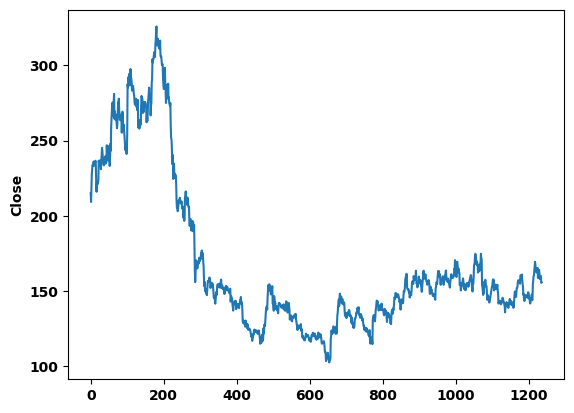

In [11]:
# load data 
import pandas as pd 
import seaborn as sns

stock_df = pd.read_csv('./NSE-TATAGLOBAL11.csv')
print(stock_df.head())

# visualize the data
sns.lineplot(data=stock_df['Close'])

In [41]:
# split data into train and test segments
print("total number of rows: ", stock_df.shape[0])
train_percentage = 0.7
stock_train = stock_df.iloc[:int(stock_df.shape[0]*train_percentage), :].Close.to_numpy()
stock_test = stock_df.iloc[int(stock_df.shape[0]*train_percentage):, :].Close.to_numpy()
print(f"Using {train_percentage*100}% of the data as training data, we have {stock_train.shape[0]} of training rows and {stock_test.shape[0]}  of testing rows.")

total number of rows:  1235
Using 70.0% of the data as training data, we have 864 of training rows and 371  of testing rows.


Unlike traditional regression problems, where we look at several feature distributions and correlations between features to create a model, time series prediction problems like this one only have one feature, time. 

Time as a feature is not very helpful at each individual timestamp. Knowing that it is `July 21, 2017, at 3:20 PM` will not help us find the stock price at this time. However, we know people make trading decisions based on events that happened recently, and existing stock prices can be decent reflections of the recent trend of trading. So if we know the stock price at `July 21, 2017, 3:20 PM`, we can probably guess the stock price at `July 21, 2017, 3:21 PM`. Thus, we can assume `local temporal dependency` and use this to make predictions. 

One approach to model this dependency is the `moving average filter`. Essentially, we average the values in a given time range close to the target timestamp, and use that as our prediction. 

Let's try this using the training dataset with different sizes. 

In [42]:
# create a moving average function 
import numpy as np 
def moving_avg(lst, size=50):
    """Moving Window Avg with a default window size of 50"""
    mov_avgs = []
    for i in range(size, len(lst)): 
        mov_avgs.append(sum(lst[i-size:i]) / size) 
    return mov_avgs

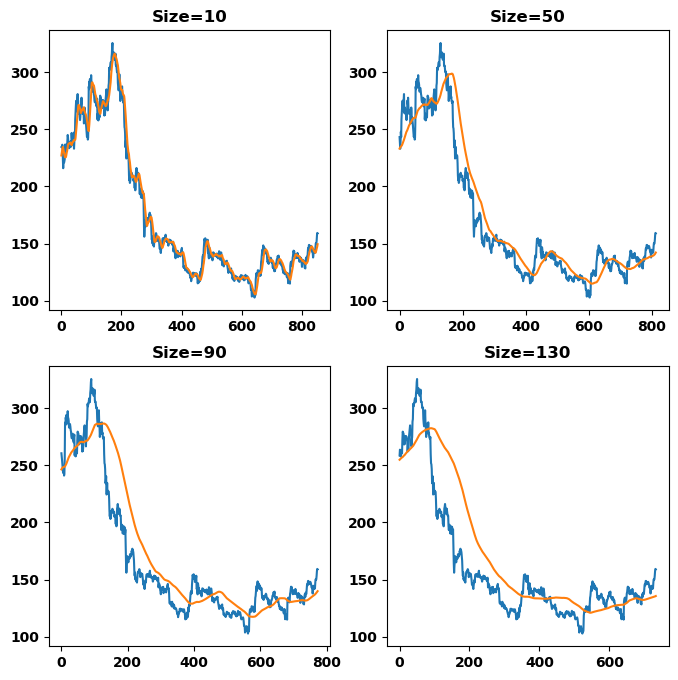

In [46]:
# visualize it against the original 
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,2, figsize=(8,8))

r,c = 0,0
for size in [10, 50, 90, 130]: 
    result = moving_avg(stock_train, size=size)
    axes[r,c].title.set_text(f'Size={size}')
    sns.lineplot(data=stock_train[size:], ax=axes[r,c])
    sns.lineplot(data=result, ax=axes[r,c])
    c+=1
    if c == 2: 
        r+=1
        c=0

#### TODO: Write more notes on the effect of different sizes

In [50]:
# normalize data for better weight values
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler((0,1))
norm_stock_train = mms.fit_transform(stock_train.reshape(-1,1))

https://medium.com/@computersgeek/deep-learning-for-predicting-stock-prices-4cf95b08b23b

https://www.askpython.com/python/examples/stock-price-prediction-python

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html


In [ ]:
# construct the feature/target pair 
size = 20
for i in range(size, len(norm_stock_train)):
     


## Image Classification 

Image classification is usually the first thing people think of when taking about computer vision, and we can see image classification model at work on a daily basis. For the second example, we will construct an effective image classification model to identify hand written digits from their picture. 

## Anomaly Detection

Anomaly detection is a category of tasks. 